In [10]:
from random_word import RandomWords
r = RandomWords()

import sys
sys.path.append("../pyvene/")

import torch
import random, copy, argparse
import pandas as pd
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer
from transformers import LlamaTokenizer
from torch.nn import CrossEntropyLoss
from transformers.activations import ACT2FN
import wandb

from pyvene import (
    IntervenableModel,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    TrainableIntervention,
    DistributedRepresentationIntervention,
)
from pyvene import create_llama
from pyvene import set_seed, count_parameters
from pyvene.models.layers import LowRankRotateLayer
import os

device = "cuda"
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"
prompt_template = """Below is an instruction that \
describes a task. Write a response that appropriately \
completes the request.

### Instruction:
%s

### Response:
"""
trigger_tokens = "### Response:\n"

class LearnedSourceLowRankRotatedSpaceIntervention(
    ConstantSourceIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention
):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
        self.learned_source = torch.nn.Parameter(
            torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)
        
    def forward(
        self, base, source=None, subspaces=None
    ):
        rotated_base = self.rotate_layer(base)
        output = base + torch.matmul(
            (self.learned_source - rotated_base), self.rotate_layer.weight.T
        )
        return output.to(base.dtype)

In [11]:
config, _, llama = create_llama("huggyllama/llama-7b")
_ = llama.to(device)  # single gpu
_ = llama.eval()  # always no grad on the model

tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b")
tokenizer.padding_side = "right" 
special_tokens_dict = dict()
if tokenizer.pad_token is None:
    special_tokens_dict["pad_token"] = DEFAULT_PAD_TOKEN
if tokenizer.eos_token is None:
    special_tokens_dict["eos_token"] = DEFAULT_EOS_TOKEN
if tokenizer.bos_token is None:
    special_tokens_dict["bos_token"] = DEFAULT_BOS_TOKEN
if tokenizer.unk_token is None:
    special_tokens_dict["unk_token"] = DEFAULT_UNK_TOKEN
num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
llama.resize_token_embeddings(len(tokenizer))
print("adding new tokens count: ", num_new_tokens)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model
adding new tokens count:  1


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


We construct a strange dataset where given a random, the model needs to generate a random English sentence in return.

Then, we train to train a 1-D linear subspace intervention that could steer the model to generate the random English sentence.

We vary the random English sentence length to measure how much that 1-D linear subspace could store.

In [27]:
# testing site
rank = 1
layers = "15"
rerun = 3
epochs = 500
initial_lr = 5e-3
        
results = {}

layers = [int(l) for l in layers.split(";")]
config = IntervenableConfig([{
    "layer": l,
    "component": "block_output",
    "low_rank_dimension": rank} for l in layers],
    LearnedSourceLowRankRotatedSpaceIntervention
)

In [28]:
for rerun_idx in range(rerun):
    for random_len in [32, 64, 128, 256, 512, 1024]:
        print(f"{rerun_idx} and {random_len}")
        all_base_input_ids, all_base_positions, all_output_ids, all_source_input_ids = [], [], [], []

        prompt = "This is a random prompt."
        base_prompt = prompt_template % prompt
        overwrite_output = [r.get_random_word() for _ in range(random_len)]
        base_input = base_prompt + " ".join(overwrite_output) + tokenizer.pad_token

        base_prompt_length = len(tokenizer(
            # we use 256 to follow previous work's cut-off length
            base_prompt, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0])
        base_input_ids = tokenizer(
            base_input, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0]
        output_ids = tokenizer(
            base_input, max_length=2048, truncation=True, return_tensors="pt")["input_ids"][0]
        base_input_ids[-1] = tokenizer.pad_token_id
        output_ids[-1] = tokenizer.pad_token_id
        output_ids[:base_prompt_length] = -100

        all_base_input_ids.append(base_input_ids)
        all_base_positions.append([base_prompt_length-1]) # intervene on the last prompt token
        all_output_ids.append(output_ids)

        raw_train = (
            all_base_input_ids,
            all_base_positions,
            all_output_ids,
        )

        train_dataset = Dataset.from_dict(
            {
                "input_ids": raw_train[0],
                "intervention_position": raw_train[1],
                "labels": raw_train[2],
            }
        ).shuffle(seed=42)

        data_collator = DataCollatorForSeq2Seq(
            tokenizer=tokenizer,
            model=llama,
            label_pad_token_id=-100,
            padding="longest"
        )

        train_dataloader = DataLoader(
            train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator)

        total_step = 0
        gradient_accumulation_steps = 1
        batch_size = 1

        train_dataloader = DataLoader(
            train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

        intervenable = IntervenableModel(config, llama)
        intervenable.set_device(device)
        intervenable.disable_model_gradients()
        
        optimizer = torch.optim.Adam(
            intervenable.get_trainable_parameters(), lr=initial_lr
        )
        intervenable.model.train()  # train enables drop-off but no grads

        for epoch in range(0, int(epochs)):
            for step, inputs in enumerate(train_dataloader):
                for k, v in inputs.items():
                    if v is not None and isinstance(v, torch.Tensor):
                        inputs[k] = v.to(device)
                b_s = inputs["input_ids"].shape[0]

                base_unit_location = inputs["intervention_position"].tolist()
                base_first_token = torch.zeros_like(inputs["intervention_position"]).tolist()
                _, cf_outputs = intervenable(
                    {"input_ids": inputs["input_ids"]},
                    unit_locations={"sources->base": (None,[
                        base_unit_location
                    ])})

                # lm loss on counterfactual labels
                lm_logits = cf_outputs.logits
                labels = inputs["labels"]
                shift_logits = lm_logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                # Flatten the tokens
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                loss_str = round(loss.item(), 2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                total_step += 1
                if loss_str == 0.0:
                    break
        if random_len not in results:
            results[random_len] = [loss_str]
        else:
            results[random_len] += [loss_str]

0 and 32
0 and 64
0 and 128
0 and 256
0 and 512
0 and 1024
1 and 32
1 and 64
1 and 128
1 and 256
1 and 512
1 and 1024
2 and 32
2 and 64
2 and 128
2 and 256
2 and 512
2 and 1024


In [29]:
results

{32: [0.0, 0.0, 0.0],
 64: [5.42, 0.01, 0.0],
 128: [1.63, 1.16, 1.95],
 256: [2.9, 3.17, 5.17],
 512: [4.34, 5.06, 4.57],
 1024: [5.11, 4.65, 4.59]}

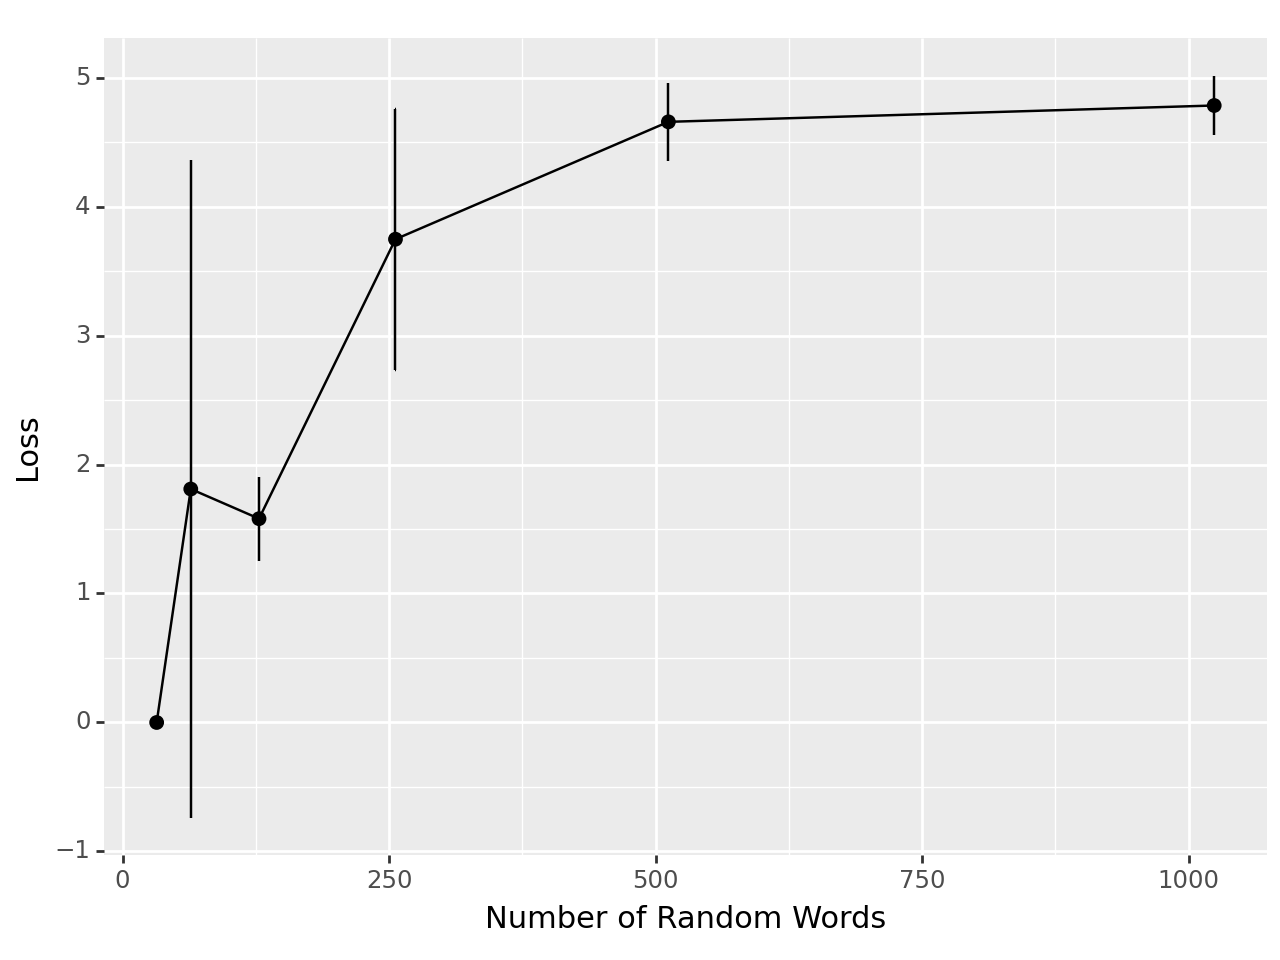

<Figure Size: (640 x 480)>

In [35]:
import pandas as pd
import numpy as np
from plotnine import ggplot, geom_point, geom_line, aes, labs, geom_errorbar

# Transforming the data into a DataFrame
data = {"x": [], "mean": [], "std": [], "variance": []}
for key, values in results.items():
    data["x"].append(key)
    data["mean"].append(np.mean(values))
    data["std"].append(np.std(values))
    data["variance"].append(np.var(values))

df = pd.DataFrame(data)

# Calculating the error (variance here is used as a proxy for error bars)
df['error'] = df['std']

# Plotting
plot = (ggplot(df, aes('x', 'mean')) +
        geom_line() +
        geom_point(size=2) +
        geom_errorbar(aes(ymin='mean-error', ymax='mean+error'), width=0.2) +
        labs(x='Number of Random Words', y='Loss'))

plot